<a href="https://colab.research.google.com/github/paulananth/Recommender-System-LightFM/blob/master/Movie_recommender_system_CF_v2_TOFILL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hands-on: movie recommender system
## Collaborative filtering (matrix factorization)

You are an online retailer/travel agent/movie review website, and you would like to help the visitors of your website to explore more of your products/destinations/movies. You got data which either describe the different products/destinations/films, or past transactions/trips/views (or preferences) of your visitors (or both!). You decide to leverage that data to provide relevant and meaningful recommendations.

This notebook implements a simple collaborative system using  factorization of the user-item matrix.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
ratings="https://github.com/couturierc/tutorials/raw/master/recommender_system/data/ratings.csv"
movies="https://github.com/couturierc/tutorials/raw/master/recommender_system/data/movies.csv"

# If data stored locally
# ratings="./data/ratings.csv"
# movies="./data/movies.csv"

df_ratings = pd.read_csv(ratings, sep=',')
df_ratings.columns = ['userId', 'itemId', 'rating', 'timestamp']
df_movies = pd.read_csv(movies, sep=',')
df_movies.columns = ['itemId', 'title', 'genres']

In [3]:
df_movies.head()

,itemId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
df_ratings.head()

,userId,itemId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


## Quick exploration

Hints: use df.describe(), df.column_name.hist(), scatterplot matrix (sns.pairplot(df[column_range])), correlation matrix (sns.heatmap(df.corr()) ), check duplicates, ...

In [5]:
df_ratings.describe()


,userId,itemId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


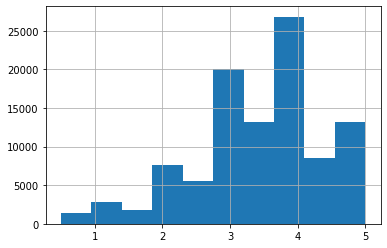

In [6]:
df_ratings.rating.hist()

In [7]:
df_ratings.columns

Index(['userId', 'itemId', 'rating', 'timestamp'], dtype='object')

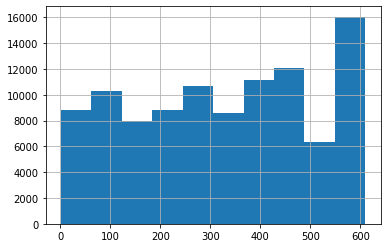

In [8]:
df_ratings.userId.hist()

## Obtain the user-item matrice by pivoting df_ratings

In [9]:
##### FILL HERE (1 line) ######
df_user_item = df_ratings.pivot(index='userId', columns='itemId', values='rating' ) #df.pivot, rows ~ userId's, columns ~ itemId's
################################

# Sort index/rows (userId's) and columns (itemId's)
df_user_item.sort_index(axis=0, inplace=True)
df_user_item.sort_index(axis=1, inplace=True)

This matrix has **many** missing values:

In [10]:
df_user_item.head()

itemId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,34,36,38,39,40,41,42,43,...,185135,185435,185473,185585,186587,187031,187541,187593,187595,187717,188189,188301,188675,188751,188797,188833,189043,189111,189333,189381,189547,189713,190183,190207,190209,190213,190215,190219,190221,191005,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,4.0,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
df_user_item.shape

(610, 9724)

For instance, rating for userId=1 for movies with itemId 1 to 10:

In [12]:
df_user_item.loc[1][:10]

itemId
1     4.0
2     NaN
3     4.0
4     NaN
5     NaN
6     4.0
7     NaN
8     NaN
9     NaN
10    NaN
Name: 1, dtype: float64

In [ ]:
# df_user_item.loc[1].dropna().sort_values(ascending=False)

Save the movie ids for user 1 for later:

In [13]:
item_rated_user_1 = df_user_item.loc[1].dropna().index
item_rated_user_1

Int64Index([   1,    3,    6,   47,   50,   70,  101,  110,  151,  157,
            ...
            3671, 3702, 3703, 3729, 3740, 3744, 3793, 3809, 4006, 5060],
           dtype='int64', name='itemId', length=232)

We want to find the matrix of rank $k$ which is closest to the original matrix.



## What not to do: Fill with 0's or mean values, then Singular Value Decomposition (SVD)

(Adapted from https://github.com/beckernick/matrix_factorization_recommenders/blob/master/matrix_factorization_recommender.ipynb)

Singular Value Decomposition decomposes a matrix $R$ into the best lower rank (i.e. smaller/simpler) approximation of the original matrix $R$. Mathematically, it decomposes R into a two unitary matrices and a diagonal matrix:

$$\begin{equation}
R = U\Sigma V^{T}
\end{equation}$$

where: 
- R is users's ratings matrix, 
- $U$ is the user "features" matrix, it represents how much users "like" each feature,
- $\Sigma$ is the diagonal matrix of singular values (essentially weights), 
- $V^{T}$ is the movie "features" matrix, it represents how relevant each feature is to each movie,

with $U$ and $V^{T}$ orthogonal.

In [17]:
df_user_item = df_user_item.fillna(0)
df_user_item.head()

itemId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,34,36,38,39,40,41,42,43,...,185135,185435,185473,185585,186587,187031,187541,187593,187595,187717,188189,188301,188675,188751,188797,188833,189043,189111,189333,189381,189547,189713,190183,190207,190209,190213,190215,190219,190221,191005,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
R = df_user_item.values

In [19]:
R

array([[4. , 0. , 4. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       ...,
       [2.5, 2. , 2. , ..., 0. , 0. , 0. ],
       [3. , 0. , 0. , ..., 0. , 0. , 0. ],
       [5. , 0. , 0. , ..., 0. , 0. , 0. ]])

Apply SVD to R (e.g. using NumPy or SciPy)

In [20]:
from scipy.sparse.linalg import svds
U, sigma, Vt = svds(R, k = 50)

What do $U$, $\Sigma$, $V^T$ look like?

In [21]:
U

array([[-0.0169691 ,  0.00367604, -0.01446425, ...,  0.01089745,
         0.06167385, -0.05555415],
       [-0.0051006 ,  0.00091157, -0.01728319, ...,  0.00442345,
        -0.01773772, -0.0058663 ],
       [ 0.00098164, -0.00537681,  0.00556381, ..., -0.00171517,
         0.00206861, -0.00135323],
       ...,
       [-0.15137458, -0.10809064,  0.05384249, ...,  0.00976291,
         0.01184704, -0.11611442],
       [ 0.00911714,  0.01038794,  0.00867598, ...,  0.03974124,
         0.01378463, -0.00757944],
       [ 0.01073109,  0.02748873, -0.05781424, ..., -0.09267536,
        -0.20218445, -0.13886488]])

In [22]:
sigma

array([ 67.8676482 ,  68.43455046,  69.07855191,  69.50676339,
        69.93495369,  70.02143448,  70.20660519,  71.70985332,
        72.46953282,  73.2246949 ,  73.45188037,  74.05266585,
        74.29201322,  74.96494138,  75.40667214,  75.6272454 ,
        76.71225804,  78.00723454,  78.84651534,  79.16948319,
        79.52408732,  80.86997674,  81.73690785,  82.40743887,
        83.04476272,  85.15393734,  86.05702164,  87.29627026,
        88.83466993,  90.42515264,  90.97607986,  92.32408574,
        93.40879296,  97.11713355,  99.28999246,  99.87323589,
       102.05675293, 105.97376877, 107.93266172, 109.60313933,
       113.11144323, 121.44217651, 122.66302989, 135.65556768,
       147.33575651, 154.552948  , 170.42250831, 191.1508762 ,
       231.23661142, 534.41989777])

In [23]:
Vt.shape

(50, 9724)

Get recommendations:

In [24]:
# First make sigma a diagonal matrix:
sigma = np.diag(sigma)

In [25]:
sigma.shape

(50, 50)

In [26]:
R_after_svd = np.dot(np.dot(U, sigma), Vt)
R_after_svd

array([[ 2.18187197e+00,  3.93674189e-01,  8.38185756e-01, ...,
        -2.49842711e-02, -2.49842711e-02, -5.89881001e-02],
       [ 2.09809067e-01,  4.82051887e-03,  3.07424005e-02, ...,
         1.88951263e-02,  1.88951263e-02,  3.19658766e-02],
       [ 1.33940814e-02,  3.47258164e-02,  5.05247472e-02, ...,
        -1.61232411e-03, -1.61232411e-03, -5.29984436e-04],
       ...,
       [ 2.30963539e+00,  2.70243898e+00,  2.26419696e+00, ...,
        -1.25165145e-02, -1.25165145e-02,  9.27520866e-02],
       [ 7.83182598e-01,  5.30142683e-01,  9.79748203e-02, ...,
         9.84577917e-04,  9.84577917e-04, -5.49383653e-03],
       [ 5.35809290e+00, -2.88817350e-01, -9.07680249e-02, ...,
        -2.79227416e-02, -2.79227416e-02,  3.55476113e-02]])

In [27]:
R_after_svd.shape

(610, 9724)

Drawbacks of this approach: 
- the missing values (here filled with 0's) is feedback that the user did not give, we should not cannot consider it negative/null rating.
- the dense matrix is huge, applying SVD is not scalable.

## Approximate SVD with stochastic gradient descend (SGD)


This time, we do **not** fill missing values. 

We inject $\Sigma$ into U and V, and try to find P and q such that $\widehat{R} = P Q^{T}$ is close to  $R$ **for the item-user pairs already rated**.


A first function to simplify the entries (userId/itemId) : we map the set of 

In [28]:
def encode_ids(data):
    '''Takes a rating dataframe and return: 
    - a simplified rating dataframe with ids in range(nb unique id) for users and movies
    - 2 mapping disctionaries
    
    '''

    data_encoded = data.copy()
    
    users = pd.DataFrame(data_encoded.userId.unique(),columns=['userId'])  # df of all unique users
    dict_users = users.to_dict()    
    inv_dict_users = {v: k for k, v in dict_users['userId'].items()}

    items = pd.DataFrame(data_encoded.itemId.unique(),columns=['itemId']) # df of all unique items
    dict_items = items.to_dict()    
    inv_dict_items = {v: k for k, v in dict_items['itemId'].items()}

    data_encoded.userId = data_encoded.userId.map(inv_dict_users)
    data_encoded.itemId = data_encoded.itemId.map(inv_dict_items)

    return data_encoded, dict_users, dict_items
  

Here is the procedure we would like to implement in the function SGD():

1.   itinialize P and Q to random values

2.   for $n_{epochs}$ passes on the data:

    *   for all known ratings $r_{ui}$
        *   compute the error between the predicted rating $p_u \cdot q_i$ and the known ratings $r_{ui}$:
        $$ err = r_{ui} - p_u \cdot q_i $$
        *   update $p_u$ and $q_i$ with the following rule:
        $$ p_u \leftarrow p_u + \alpha \cdot err \cdot q_i  $$
        $$ q_i \leftarrow q_i + \alpha \cdot err \cdot p_u$$







In [29]:
  data, dict_users, dict_items = encode_ids(df_ratings)

In [30]:
len(data.userId.unique())
len(data.itemId.unique())

9724

In [ ]:
# Adapted from http://nicolas-hug.com/blog/matrix_facto_4
def SGD(data,           # dataframe containing 1 user|item|rating per row
        n_factors = 10, # number of factors
        alpha = .01,    # number of factors
        n_epochs = 3,   # number of iteration of the SGD procedure
       ):
    '''Learn the vectors P and Q (ie all the weights p_u and q_i) with SGD.
    '''

    # Encoding userId's and itemId's in data
    data, dict_users, dict_items = encode_ids(data)
    
    ##### FILL HERE (2 lines) ######
    n_users = data.userId.nunique()  # number of unique users
    n_items = data.itemId.nunique()  # number of unique items
    ################################
    
    # Randomly initialize the user and item factors.
    p = np.random.normal(0, .1, (n_users, n_factors)).astype(np.float128)
    q = np.random.normal(0, .1, (n_items, n_factors)).astype(np.float128)

    # Optimization procedure
    for epoch in range(n_epochs):
        print ('epoch: ', epoch)
        # Loop over the rows in data
        for index in range(data.shape[0]):
            row = data.iloc[[index]]
            u = int(row.userId)      # current userId = position in the p vector (thanks to the encoding)
            i = int(row.itemId)      # current itemId = position in the q vector
            r_ui = float(row.rating) # rating associated to the couple (user u , item i)
            
            ##### FILL HERE (1 line) ######
            err = r_ui + np.dot(p[u], (q[i]).transpose())    # difference between the predicted rating (p_u . q_i) and the known ratings r_ui
            ################################
            
            # Update vectors p_u and q_i
            ##### FILL HERE (2 lines) ######
            p_old = p[u]
            p[u] = p[u] + alpha * err * q[i]  # cf. update rule above 
            q[i] = q[i] + alpha * err * p_old
            ################################
            
    return p, q
    
    
def estimate(u, i, p, q):
    '''Estimate rating of user u for item i.'''
    ##### FILL HERE (1 line) ######
    return NULL             #scalar product of p[u] and q[i] /!\ dimensions
    ################################  

In [ ]:
p, q = SGD(df_ratings)

epoch:  0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in multiply


epoch:  1


In [ ]:
q

## Get the estimate for all user-item pairs:

Get the user-item matrix filled with predicted ratings:

In [ ]:
df_user_item_filled = pd.DataFrame(np.dot(p, q.transpose()))
df_user_item_filled.head()

However, it is using the encode ids ; we need to retrieve the association of encoded ids to original ids, and apply it:

In [ ]:
df_ratings_encoded, dict_users, dict_items = encode_ids(df_ratings)

In [ ]:
df_user_item_filled.rename(columns=(dict_items['itemId']), inplace=True)
df_user_item_filled.rename(index=(dict_users['userId']), inplace=True)

# Sort index/rows (userId's) and columns (itemId's)
df_user_item_filled.sort_index(axis=0, inplace=True)
df_user_item_filled.sort_index(axis=1, inplace=True)

df_user_item_filled.head()

Originally available ratings for user 1:

In [ ]:
df_user_item.loc[1][:10]

Estimated ratings after the approximate SVD:

In [ ]:
df_user_item_filled.loc[1][:10]

## Give recommendation to a user

For instance 10 recommended movies for user 1

In [ ]:
recommendations = list((df_user_item_filled.loc[10]).sort_values(ascending=False)[:10].index)
recommendations

In [ ]:
df_movies[df_movies.itemId.isin(recommendations)]

vs the ones that were rated initially:

In [ ]:
already_rated = list((df_user_item.loc[10]).sort_values(ascending=False)[:10].index)
already_rated

In [ ]:
df_movies[df_movies.itemId.isin(already_rated)]

This is all the movies in descending order of predicted rating. Let's remove the ones that where alread rated.




---



To put this into production, you'd first separate data into a training and validation set and optimize the number of latent factors (n_factors) by minimizing the Root Mean Square Error. 
It is easier to use a framework that allows to do this, do cross-validation, grid search, etc.

# Gradient Descent SVD using Surprise

In [ ]:
!pip install surprise
#!pip install scikit-surprise # if the first line does not work

In [ ]:
# from surprise import Reader, Dataset, SVD, evaluate

# Following Surprise documentation examples 
# https://surprise.readthedocs.io/en/stable/getting_started.html

from surprise import Reader, Dataset, SVD, evaluate, NormalPredictor
from surprise.model_selection import cross_validate
from collections import defaultdict

# As we're loading a custom dataset, we need to define a reader.
reader = Reader(rating_scale=(0.5, 5))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(df_ratings[['userId', 'itemId', 'rating']], reader)

# We'll use the famous SVD algorithm.
algo = SVD()

# Run 5-fold cross-validation and print results
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

#### Tune algorithm parameters with GridSearchCV



In [ ]:
from surprise.model_selection import GridSearchCV

param_grid = {'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

In [ ]:
# We can now use the algorithm that yields the best rmse:
algo = gs.best_estimator['rmse']
trainset = data.build_full_trainset()
algo.fit(trainset)

In [ ]:
algo.predict(621,1)

In [ ]:
df_data = data.df
df_data = df_data.join(df_movies,how="left", on='itemId',rsuffix='_', lsuffix='')
df_data[df_data['userId']==1].sort_values(by = 'rating',ascending=False)[:10]

In [ ]:
# From Surprise documentation: https://surprise.readthedocs.io/en/stable/FAQ.html
def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [ ]:
# Predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()
predictions = algo.test(testset)

In [ ]:
top_n = get_top_n(predictions, n=10)

In [ ]:
top_n.items()

In [ ]:
# Print the recommended items for all user 1
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])
    if uid == 1:
        break

In [ ]:
df_movies[df_movies.itemId.isin([318, 750, 1204, 858, 904, 48516, 1221, 912, 1276, 4973])]